Sebastian Raschka, 2015

# Python Machine Learning Essentials

# Building Good Training Sets – Data Pre-Processing

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -u -d -v -p numpy,pandas,matplotlib,scikit-learn

Sebastian Raschka 
Last updated: 09/09/2015 

CPython 3.4.3
IPython 4.0.0

numpy 1.9.2
pandas 0.16.2
matplotlib 1.4.3
scikit-learn 0.16.1


In [2]:
# to install watermark just uncomment the following line:
#%install_ext https://raw.githubusercontent.com/rasbt/watermark/master/watermark.py

<br>
<br>

### Sections



- [Dealing with missing data](#Dealing-with-missing-data)
    - [Eliminating samples or features with missing values](#Eliminating-samples-or-features-with-missing-values)
    - [Imputing missing values](#Imputing-missing-values)
    - [Understanding the scikit-learn estimator API](#Understanding-the-scikit-learn-estimator-API)
- [Handling categorical data](#Handling-categorical-data)
    - [Mapping ordinal features](#Mapping-ordinal-features)
    - [Encoding class labels](#Encoding-class-labels)
    - [Performing one-hot encoding on nominal features](#Performing-one-hot-encoding-on-nominal-features)
- [Partitioning a dataset in training and test sets](#Partitioning-a-dataset-in-training-and-test-sets)
- [Bringing features onto the same scale](#Bringing-features-onto-the-same-scale)
- [Selecting meaningful features](#Selecting-meaningful-features)
    - [Sparse solutions with L1-regularization](#Sparse-solutions-with-L1-regularization)
    - [Sequential feature selection algorithms](#Sequential-feature-selection-algorithms)
    - [Assessing Feature Importances with Random Forests](#Assessing-Feature-Importances-with-Random-Forests)

<br>
<br>

# Dealing with missing data

[[back to top](#Sections)]

In [3]:
import pandas as pd
from io import StringIO

csv_data = '''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''

# If you are using Python 2.7, you need
# to convert the string to unicode:
# csv_data = unicode(csv_data)

df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1,2,3,4
1,5,6,NaN,8
2,10,11,12,NaN


In [4]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

<br>
<br>

## Eliminating samples or features with missing values

[[back to top](#Sections)]

In [5]:
df.dropna()

,A,B,C,D
0,1,2,3,4


In [6]:
df.dropna(axis=1)

,A,B
0,1,2
1,5,6
2,10,11


In [7]:
# only drop rows where all columns are NaN
df.dropna(how='all')  

,A,B,C,D
0,1,2,3,4
1,5,6,NaN,8
2,10,11,12,NaN


In [8]:
# drop rows that have not at least 4 non-NaN values
df.dropna(thresh=4)

,A,B,C,D
0,1,2,3,4


In [9]:
# only drop rows where NaN appear in specific columns (here: 'C')
df.dropna(subset=['C'])

,A,B,C,D
0,1,2,3,4
2,10,11,12,NaN


<br>
<br>

## Imputing missing values

In [10]:
from sklearn.preprocessing import Imputer

imr = Imputer(missing_values='NaN', strategy='mean', axis=0)
imr = imr.fit(df)
imputed_data = imr.transform(df.values)
imputed_data

array([[  1. ,   2. ,   3. ,   4. ],
       [  5. ,   6. ,   7.5,   8. ],
       [ 10. ,  11. ,  12. ,   6. ]])

In [11]:
df.values

array([[  1.,   2.,   3.,   4.],
       [  5.,   6.,  nan,   8.],
       [ 10.,  11.,  12.,  nan]])

<br>
<br>

# Handling categorical data

[[back to top](#Sections)]

In [12]:
import pandas as pd
df = pd.DataFrame([
            ['green', 'M', 10.1, 'class1'], 
            ['red', 'L', 13.5, 'class2'], 
            ['blue', 'XL', 15.3, 'class1']])

df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


<br>
<br>

## Mapping ordinal features

[[back to top](#Sections)]

In [13]:
size_mapping = {
           'XL': 3,
           'L': 2,
           'M': 1}

df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


In [14]:
inv_size_mapping = {v: k for k, v in size_mapping.items()}
df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

<br>
<br>

## Encoding class labels

[[back to top](#Sections)]

In [15]:
import numpy as np

class_mapping = {label:idx for idx,label in enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

In [16]:
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,0
1,red,2,13.5,1
2,blue,3,15.3,0


In [17]:
inv_class_mapping = {v: k for k, v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


In [18]:
from sklearn.preprocessing import LabelEncoder

class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([0, 1, 0])

In [19]:
class_le.inverse_transform(y)

array(['class1', 'class2', 'class1'], dtype=object)

<br>
<br>

## Performing one-hot encoding on nominal features

[[back to top](#Sections)]

In [20]:
X = df[['color', 'size', 'price']].values

color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

In [21]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(categorical_features=[0])
ohe.fit_transform(X).toarray()

array([[  0. ,   1. ,   0. ,   1. ,  10.1],
       [  0. ,   0. ,   1. ,   2. ,  13.5],
       [  1. ,   0. ,   0. ,   3. ,  15.3]])

In [22]:
pd.get_dummies(df[['price', 'color', 'size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,0,1,0
1,13.5,2,0,0,1
2,15.3,3,1,0,0


<br>
<br>

# Partitioning a dataset in training and test sets

[[back to top](#Sections)]

In [23]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 
'Alcalinity of ash', 'Magnesium', 'Total phenols', 
'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 
'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [24]:
from sklearn.cross_validation import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.3, random_state=0)

<br>
<br>

# Bringing features onto the same scale

[[back to top](#Sections)]

In [25]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

In [26]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

A visual example:

In [27]:
ex = pd.DataFrame([0, 1, 2 ,3, 4, 5])

# standardize
ex[1] = (ex[0] - ex[0].mean()) / ex[0].std()
# normalize
ex[2] = (ex[0] - ex[0].min()) / (ex[0].max() - ex[0].min())
ex.columns = ['input', 'standardized', 'normalized']
ex

,input,standardized,normalized
0,0,-1.336306,0.0
1,1,-0.801784,0.2
2,2,-0.267261,0.4
3,3,0.267261,0.6
4,4,0.801784,0.8
5,5,1.336306,1.0


<br>
<br>

# Selecting meaningful features

[[back to top](#Sections)]

<br>
<br>

## Sparse solutions with L1-regularization

[[back to top](#Sections)]

In [28]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1', C=0.1)
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 0.983870967742
Test accuracy: 0.981481481481


In [29]:
lr.intercept_

array([-0.38380467, -0.15807921, -0.70047367])

In [30]:
lr.coef_

array([[ 0.28026118,  0.        ,  0.        , -0.02802058,  0.        ,
         0.        ,  0.71008989,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.23627238],
       [-0.64400849, -0.06880484, -0.05721606,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.92673184,
         0.06029066,  0.        , -0.37110433],
       [ 0.        ,  0.0614959 ,  0.        ,  0.        ,  0.        ,
         0.        , -0.63561841,  0.        ,  0.        ,  0.49776391,
        -0.35831392, -0.5717467 ,  0.        ]])

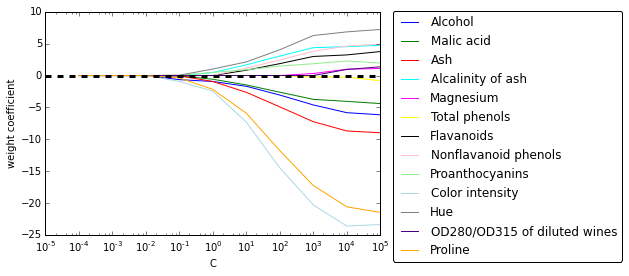

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = plt.subplot(111)
    
colors = ['blue', 'green', 'red', 'cyan', 
         'magenta', 'yellow', 'black', 
          'pink', 'lightgreen', 'lightblue', 
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4, 6):
    lr = LogisticRegression(penalty='l1', C=10**c, random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_wine.columns[column+1],
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', 
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
# plt.savefig('./figures/l1_path.png', dpi=300)
plt.show()

<br>
<br>

## Sequential feature selection algorithms

[[back to top](#Sections)]

In [28]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
                train_test_split(X, y, test_size=self.test_size, 
                                 random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

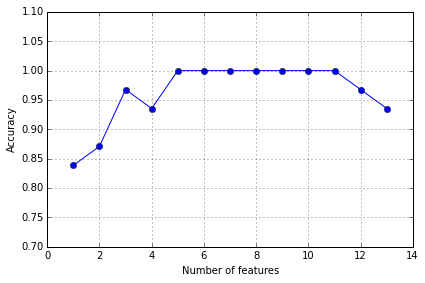

In [29]:
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

knn = KNeighborsClassifier(n_neighbors=2)

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('./sbs.png', dpi=300)
plt.show()

In [30]:
k5 = list(sbs.subsets_[8])
print(df_wine.columns[1:][k5])

Index(['Alcohol', 'Malic acid', 'Alcalinity of ash', 'Hue', 'Proline'], dtype='object')


In [31]:
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy: 0.983870967742
Test accuracy: 0.944444444444


In [32]:
knn.fit(X_train_std[:, k5], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k5], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k5], y_test))

Training accuracy: 0.959677419355
Test accuracy: 0.962962962963


<br>
<br>

# Assessing Feature Importances with Random Forests

[[back to top](#Sections)]

 1) Alcohol                        0.182508
 2) Malic acid                     0.158574
 3) Ash                            0.150954
 4) Alcalinity of ash              0.131983
 5) Magnesium                      0.106564
 6) Total phenols                  0.078249
 7) Flavanoids                     0.060717
 8) Nonflavanoid phenols           0.032039
 9) Proanthocyanins                0.025385
10) Color intensity                0.022369
11) Hue                            0.022070
12) OD280/OD315 of diluted wines   0.014655
13) Proline                        0.013933


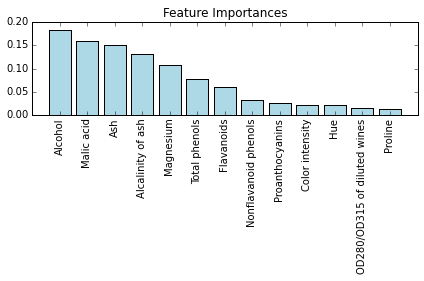

In [33]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=10000,
                                random_state=0,
                                n_jobs=-1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[f], 
                            importances[indices[f]]))

plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
# plt.savefig('./figures/random_forest.png', dpi=300)
plt.show()

In [34]:
X_selected = forest.transform(X_train, threshold=0.15)
X_selected.shape

(124, 3)